In [2]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import cv2

from superpoint.settings import DATA_PATH, EXPER_PATH
from superpoint.models.utils import detector_head, homography_adaptation, box_nms
from superpoint.models.backbones.vgg import vgg_backbone
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2
tf.logging.set_verbosity(0)

In [113]:
image_name = 'COCO_train2014_000000519723.jpg' #'COCO_train2014_000000130745.jpg' #'COCO_train2014_000000000071.jpg' #'COCO_train2014_000000114404.jpg' #'COCO_train2014_000000151493.jpg' #
model_name = 'magic-point_synth-120-160_noise-motion'

In [114]:
base_path = Path(DATA_PATH, 'COCO/train2014/')
filename = Path(base_path, image_name)
checkpoint = Path(EXPER_PATH, model_name) 

In [115]:
net_config = {
    'data_format': 'channels_last',
    'grid_size': 8,
    'detection_threshold': 1/65.,
    'nms': 4,
    'top_k': 300,
    'homography_adaptation': {
        'num': 1000, 
        'aggregation': 'sum',
        'homographies': {
            'translation': True,
            'rotation': True,
            'scaling': True,
            'perspective': True,
            'scaling_amplitude': 0.1,
            'perspective_amplitude': 0.05,
        },
        'filter_counts': 10,
    },
    'training': False
}
def net(image):
    with tf.variable_scope('magicpoint', reuse=tf.AUTO_REUSE):
        image = tf.expand_dims(image, axis=0)
        features = vgg_backbone(image, **net_config)
        outputs = detector_head(features, **net_config)
        return {k: v[0] for k, v in outputs.items()}

In [116]:
tf.reset_default_graph(), 
image = tf.image.decode_jpeg(tf.read_file(str(filename)), channels=1)
image = tf.to_float(tf.image.resize_images(image, [240, 320]))
outputs = homography_adaptation(image, net, net_config['homography_adaptation'])
outputs['prob_nms'] = box_nms(outputs['prob'], net_config['nms'], keep_top_k=net_config['top_k'])
outputs['pred'] = tf.to_int32(tf.greater_equal(outputs['prob_nms'], net_config['detection_threshold']))

In [117]:
def draw_keypoints(img, corners, color, s = 4):
    keypoints = [cv2.KeyPoint(c[1]*s, c[0]*s, 1) for c in np.stack(corners).T]
    img = cv2.resize(img, None, fx=s, fy=s)
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

300 detections


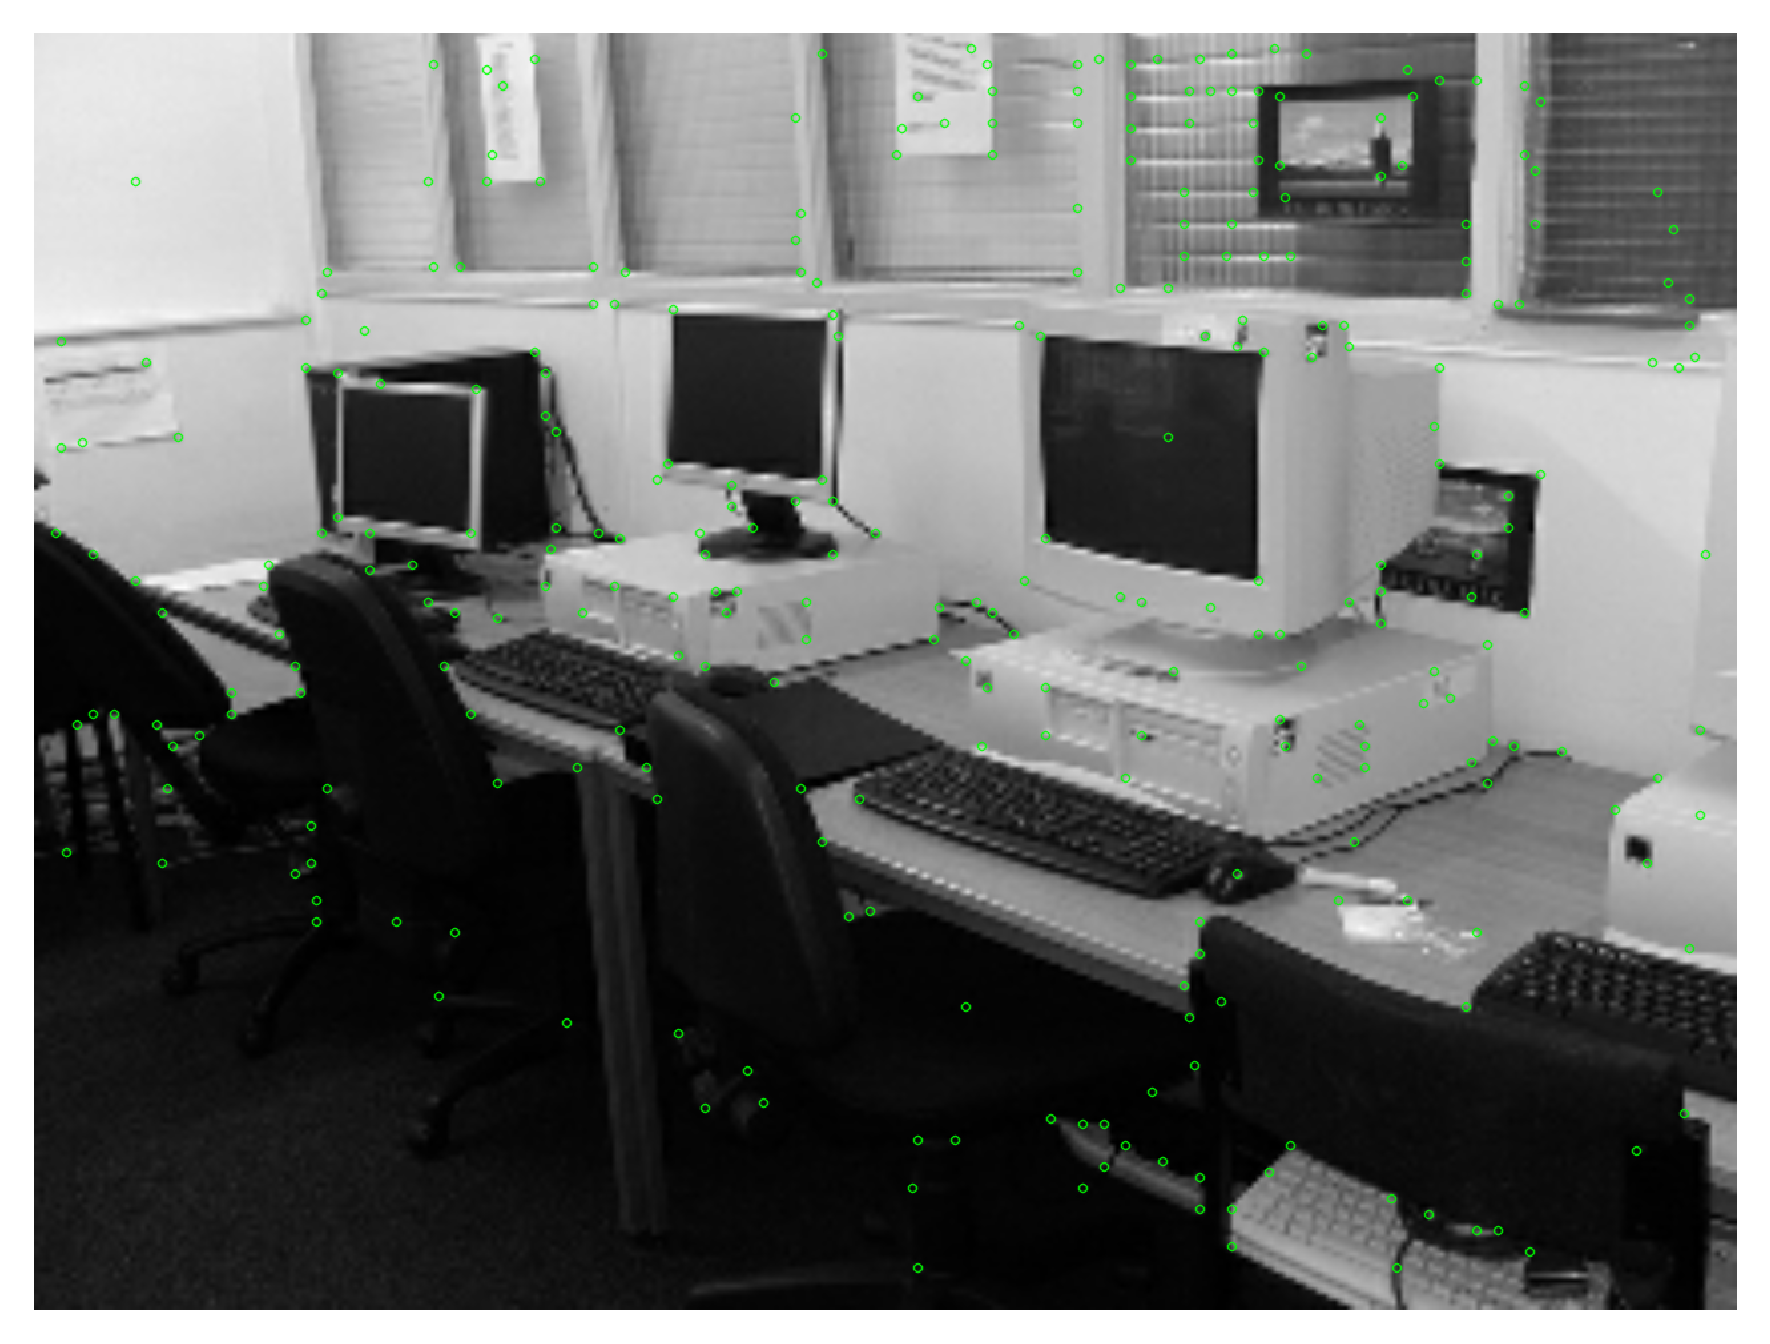

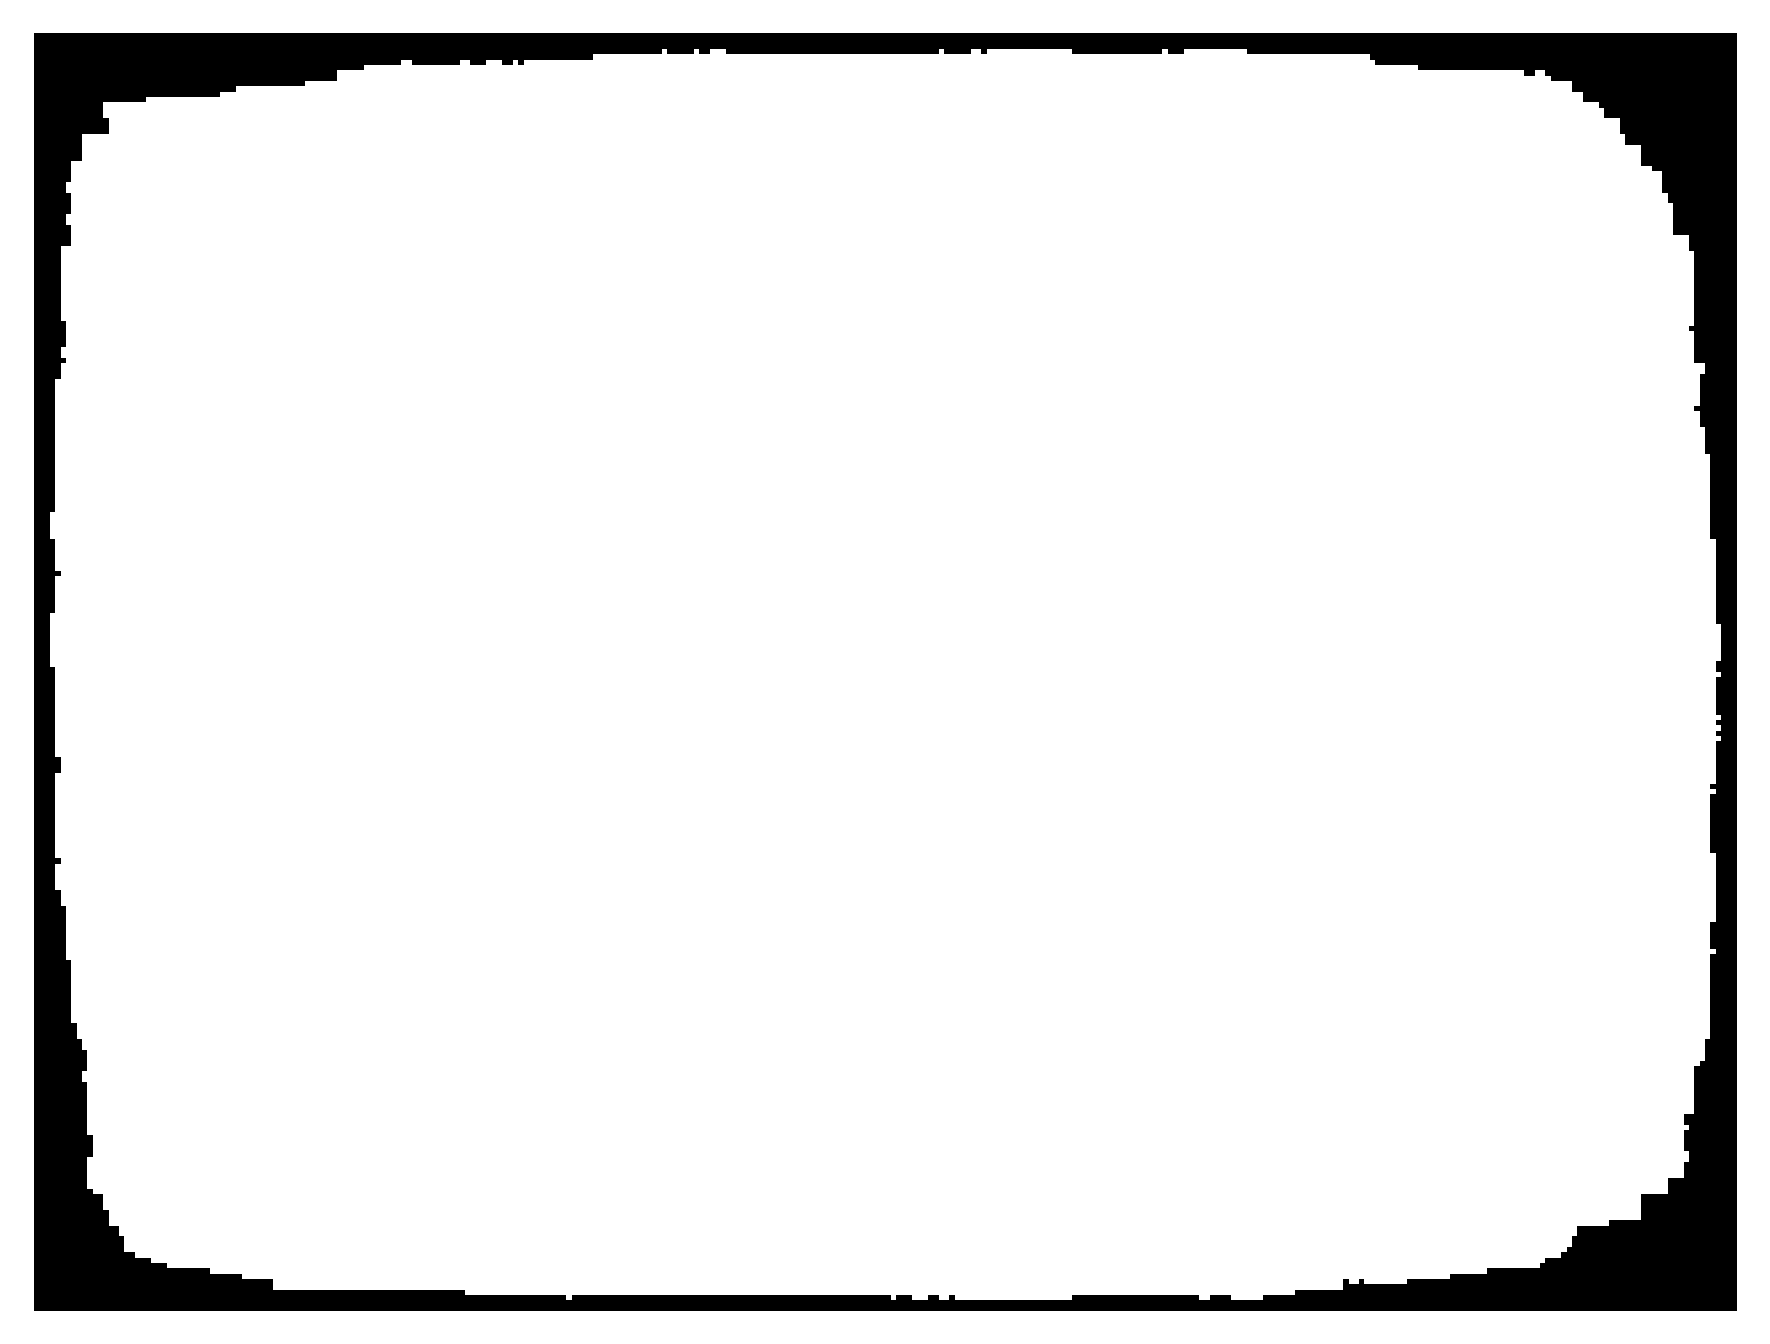

In [118]:
with tf.Session() as sess:
    tf.train.Saver().restore(sess, tf.train.latest_checkpoint(checkpoint));
    im, _out = sess.run([image, outputs])
    plot_imgs([draw_keypoints(im[..., 0], np.where(_out['pred']), (0, 255, 0))/255.], dpi=300)
    plot_imgs([_out['counts']>net_config['homography_adaptation']['filter_counts']], cmap='gray', dpi=300)
    print('{} detections'.format(np.sum(_out['pred'])))

## Mean proability: without NMS

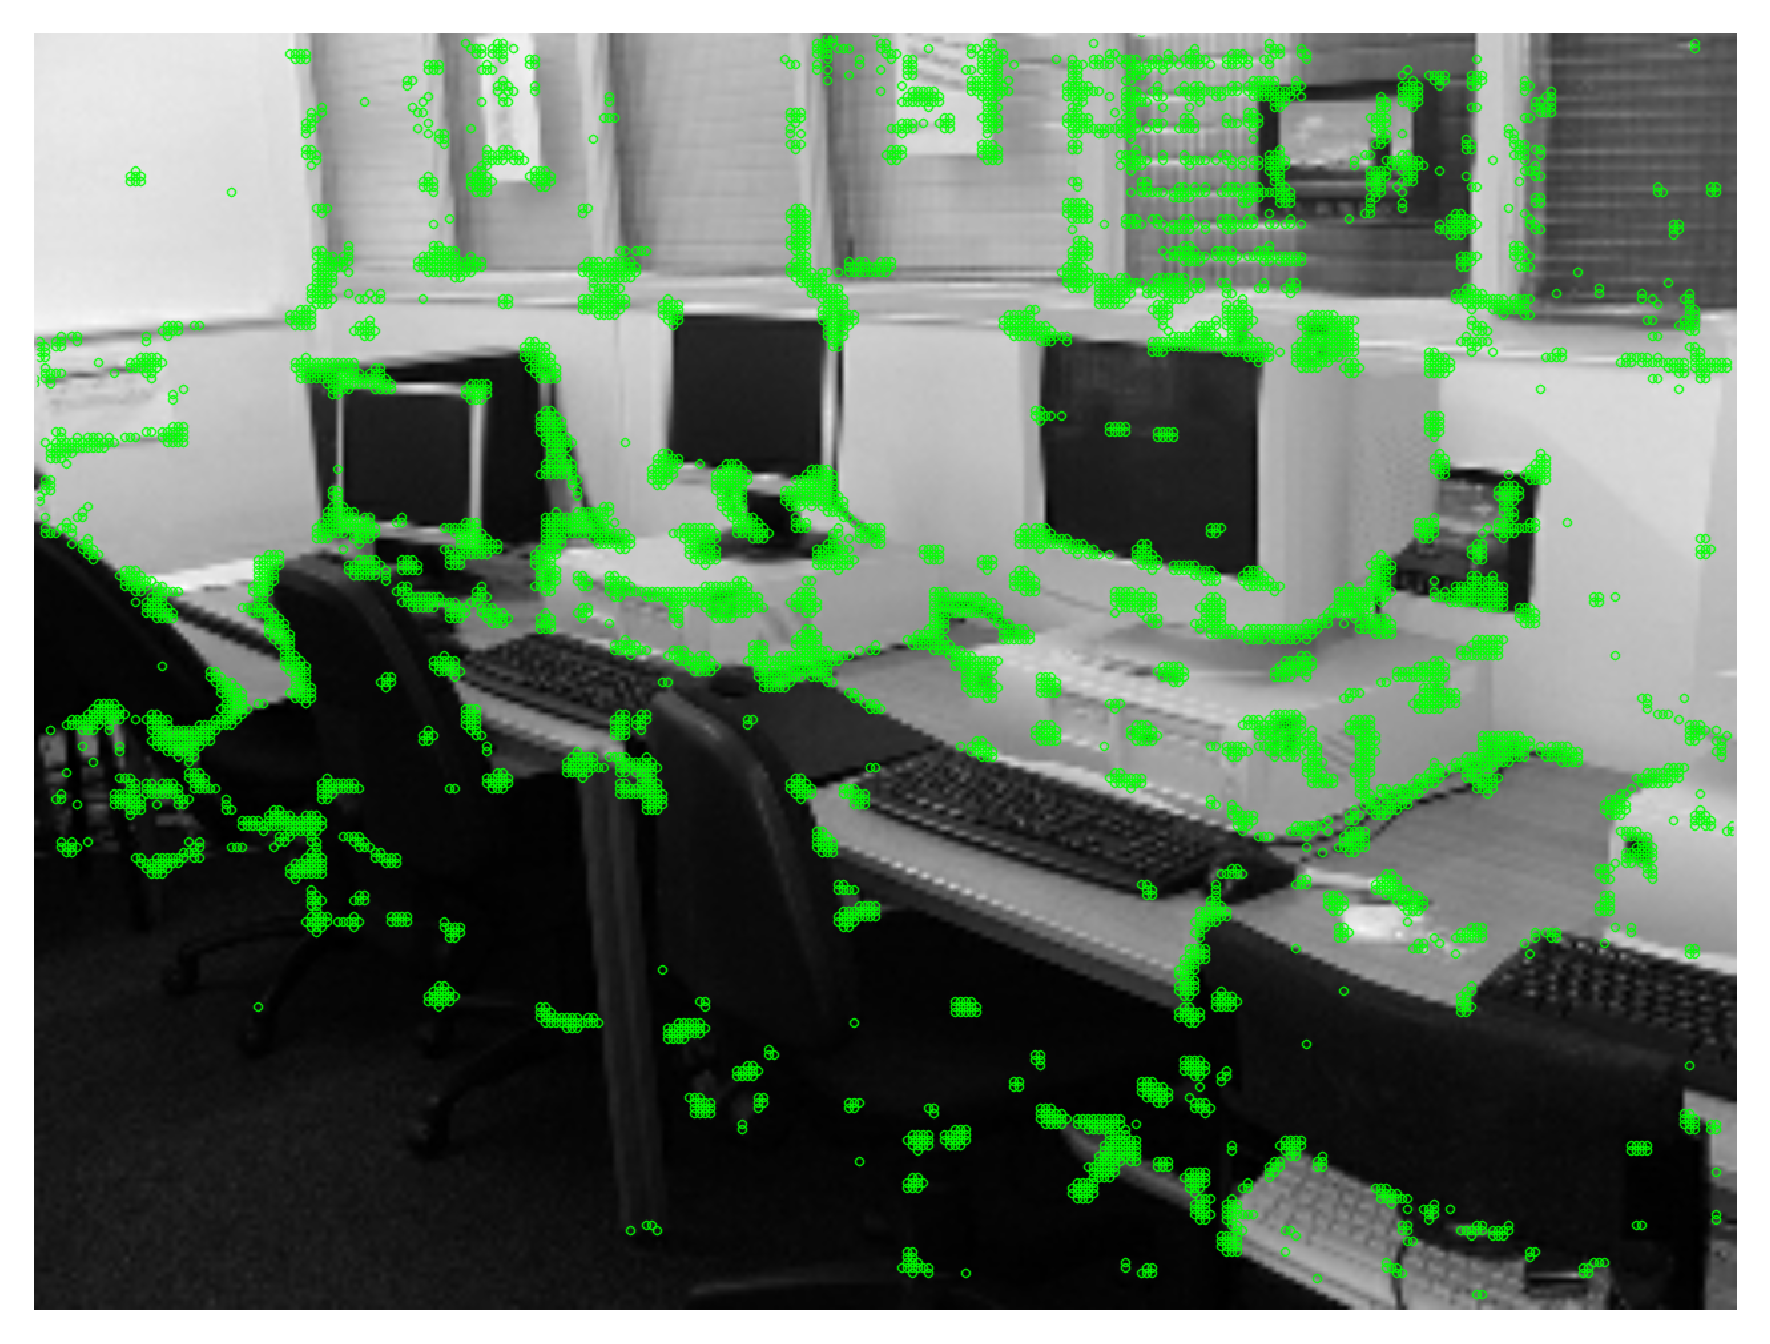

In [119]:
plot_imgs([draw_keypoints(im[..., 0], np.where(_out['mean_prob']>1/65.), (0, 255, 0))/255.], dpi=300)

## Mean proability: top 300 without NMS

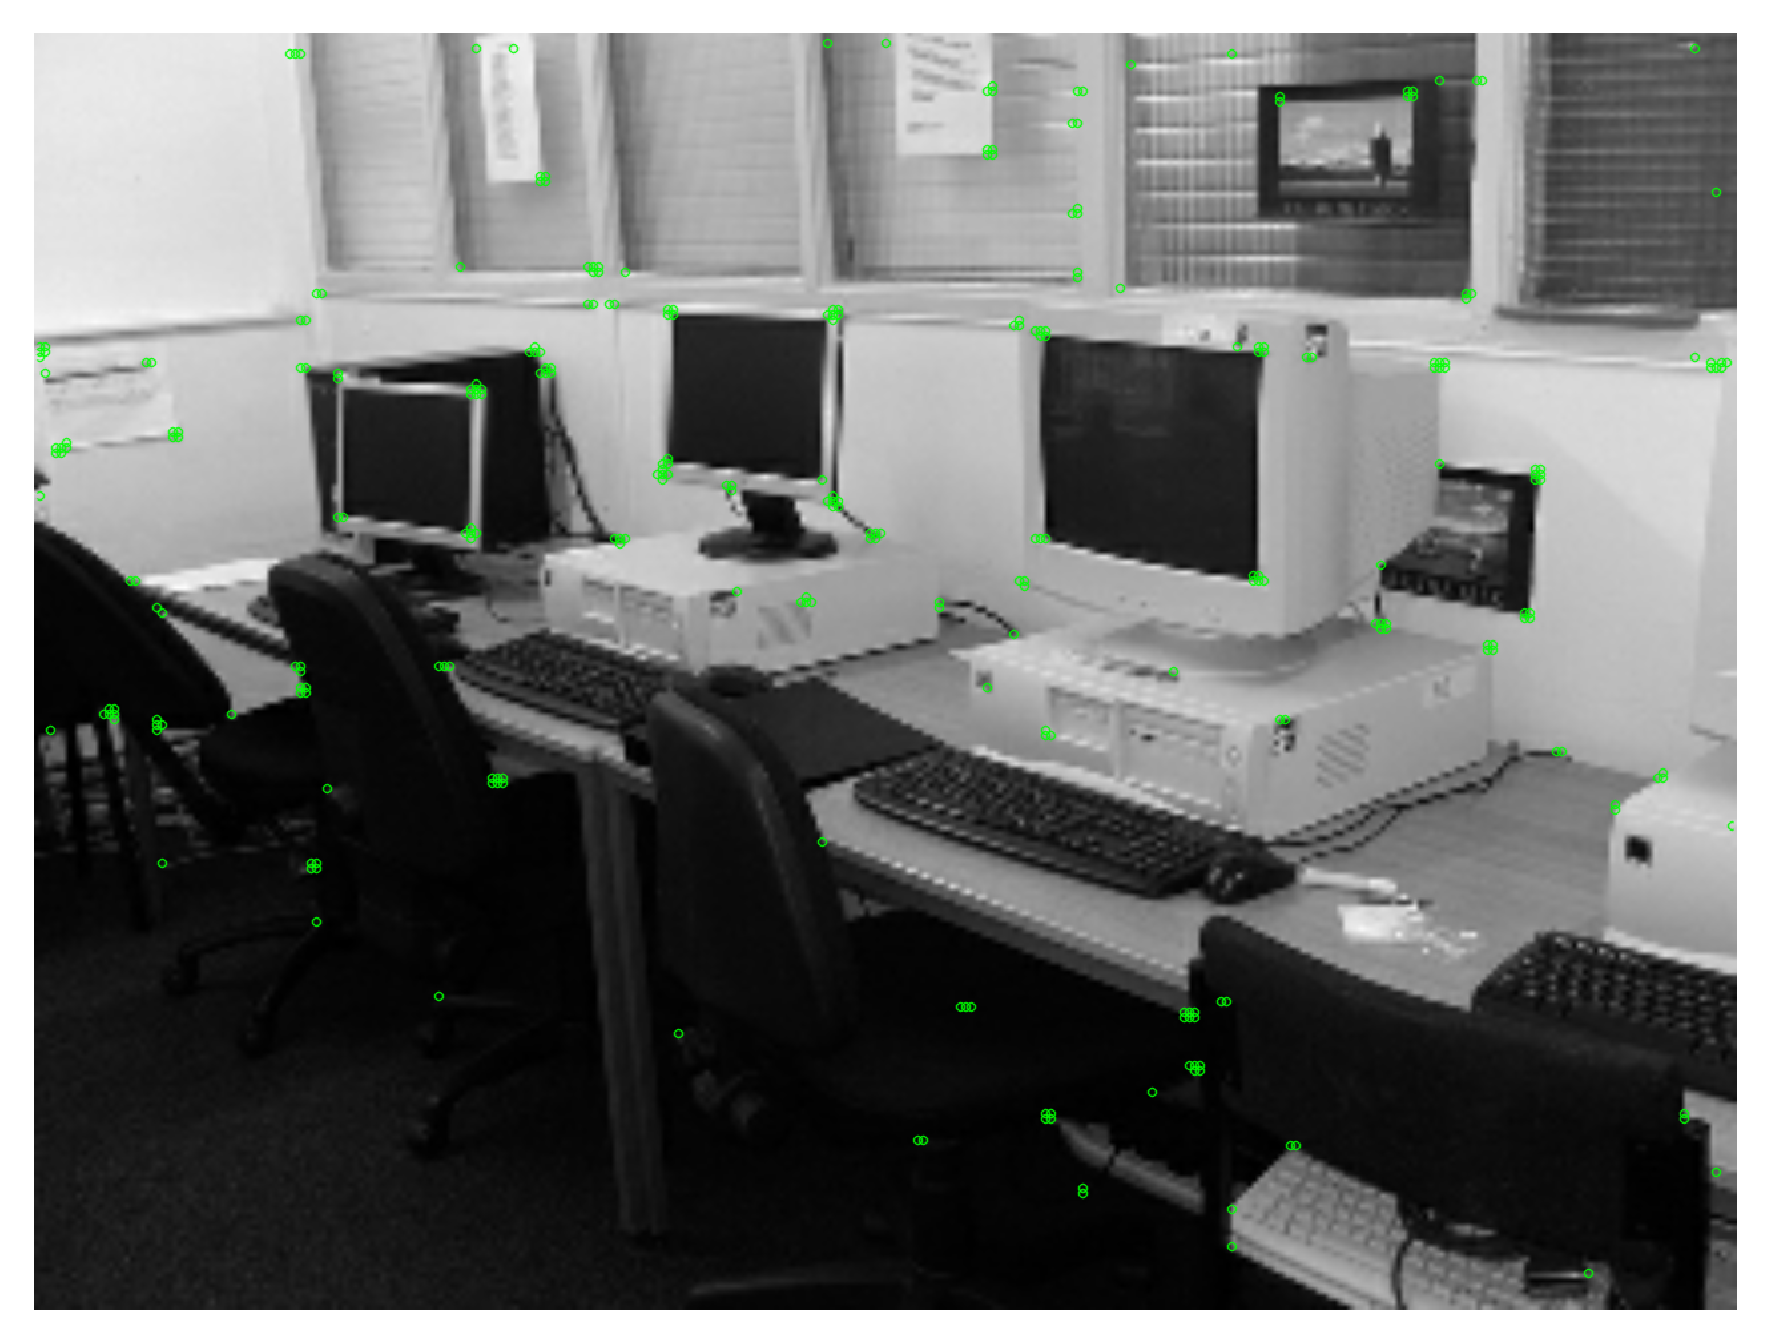

In [120]:
i = np.where(_out['mean_prob']>1/65.)
a = np.argsort(_out['mean_prob'][i])[::-1][:300]
plot_imgs([draw_keypoints(im[..., 0], (i[0][a], i[1][a]), (0, 255, 0))/255.], dpi=300)

## Without homography adaptation: poor repeatability

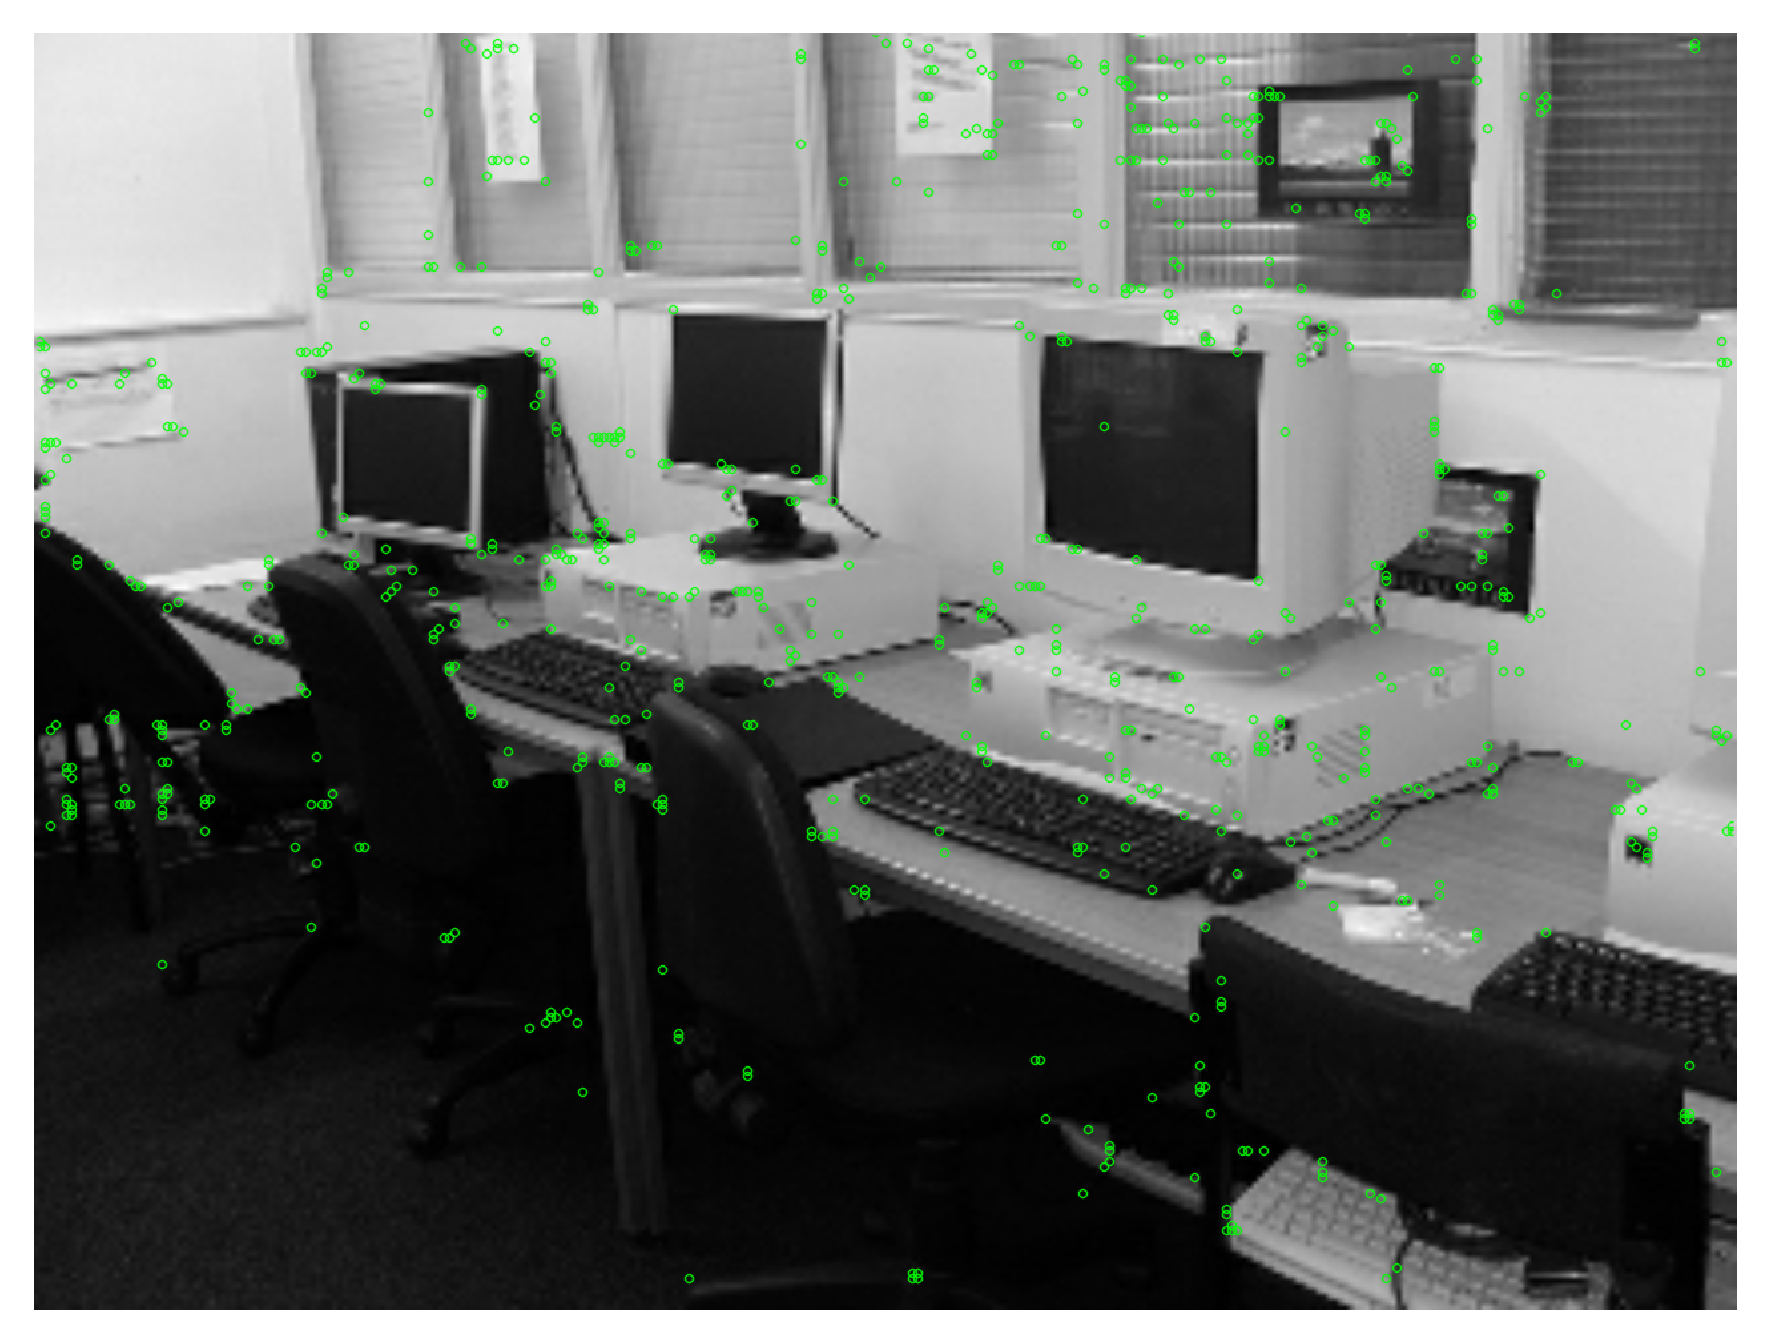

In [121]:
plot_imgs([draw_keypoints(im[..., 0], np.where(_out['H_probs'][0]>1/65.), (0, 255, 0))/255.], dpi=300)

## Distribution of the homographies

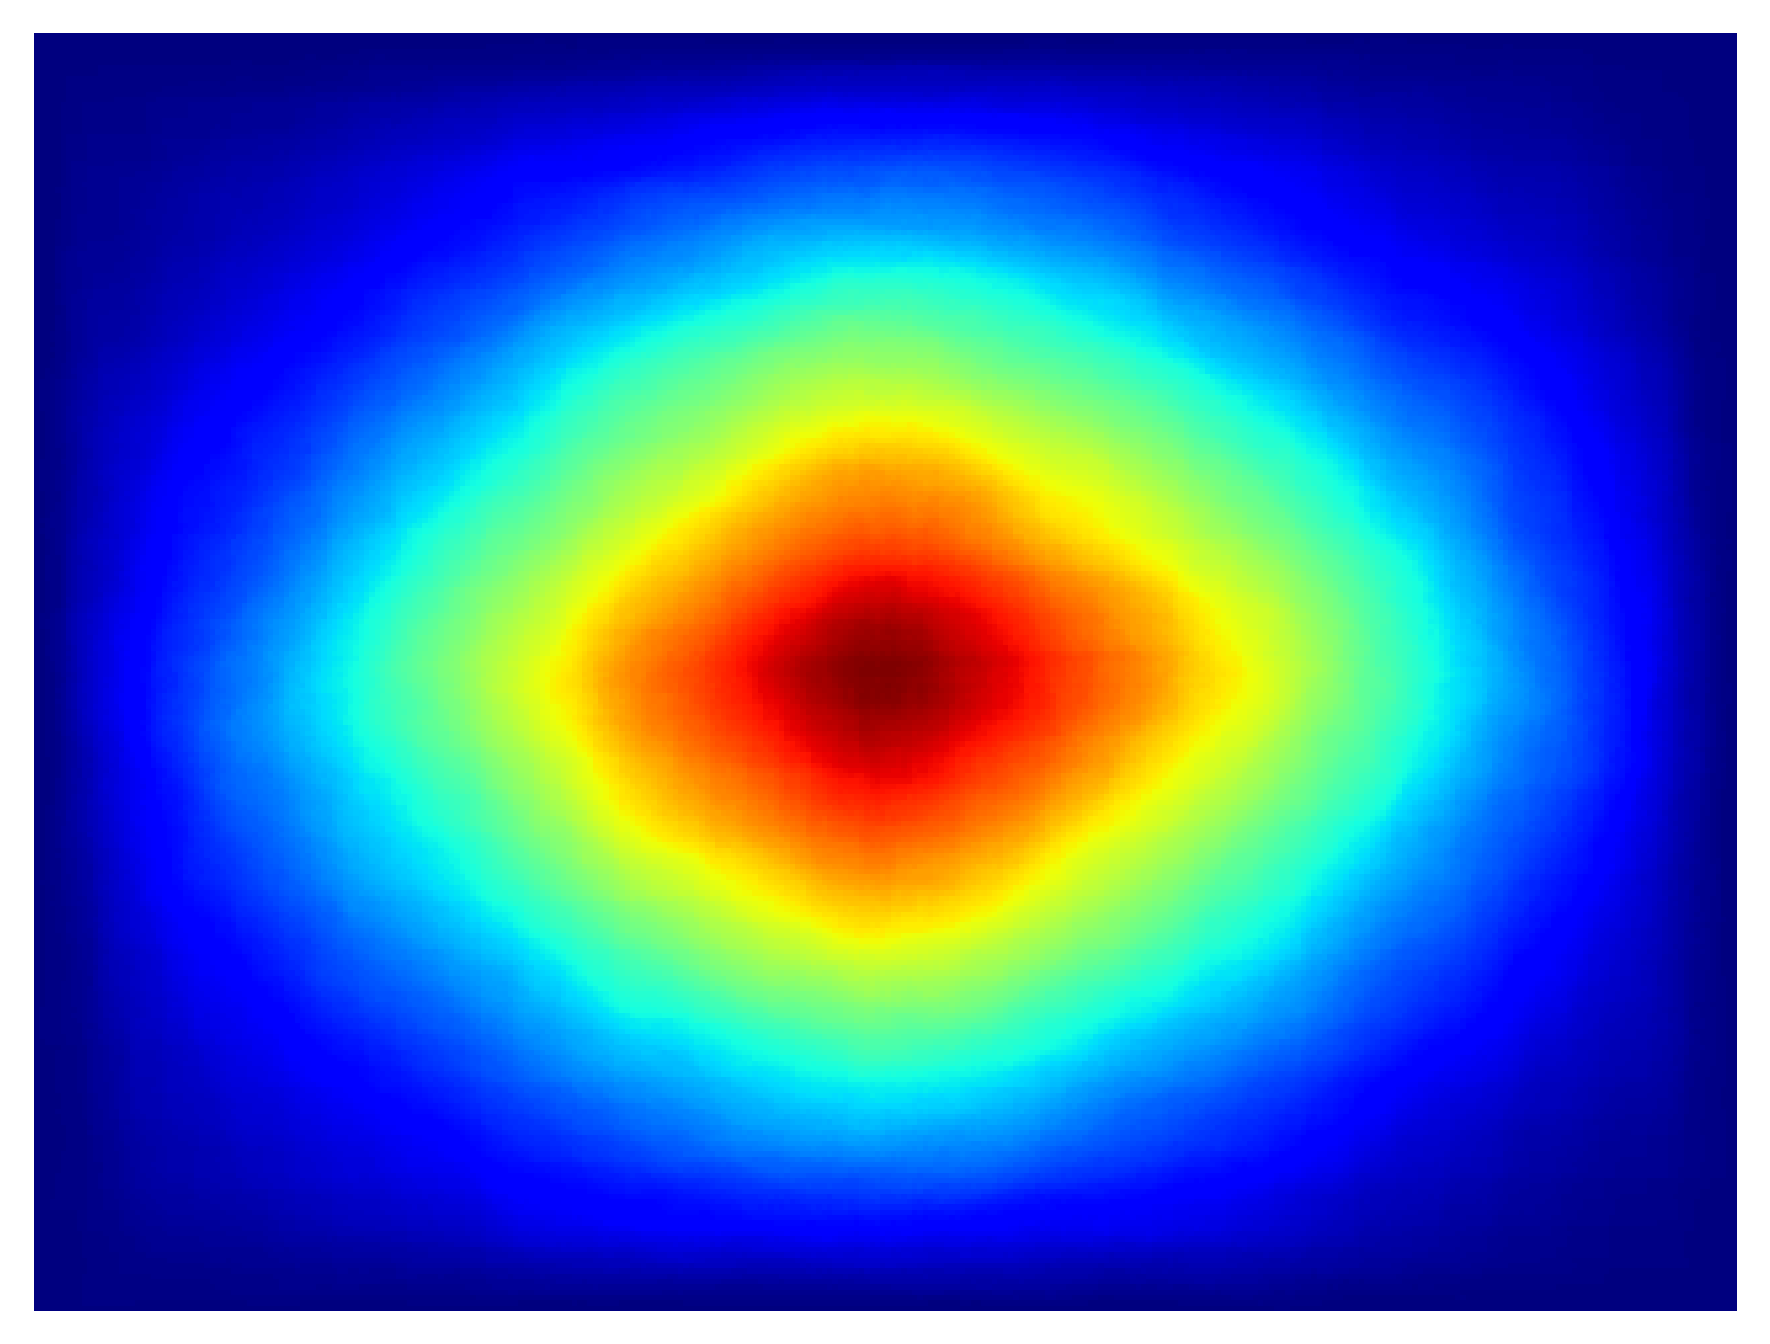

In [122]:
plot_imgs([_out['counts']/np.max(_out['counts'])], cmap='jet', dpi=300)